# Boilerplate

In [1]:
import time
import random
import copy
import numpy as np
import pandas as pd
import seaborn as sns
from collections import deque
import multiprocessing as mp
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement

In [2]:
random.seed(0)

# Parameters

In [4]:
experiment_info = {'num_run': 1, 'num_episodes': 10, "num_steps": 1000}

market_info = {
    'num_sellers': 5, 'num_buyers': 5, 'group_size': 3, 'max_capacity': 15, 'rating_step':1, 'prob_good_failure': 0.1,
    'price': np.array([10,20]), 'repair': np.array([5,10]), 'buffer_size': 10
    }

In [5]:
prob_bproblem_fail = np.round(np.arange(start=0, stop=1.2, step=0.3),2)
prob_overcharge_detected = np.round(np.arange(start=0, stop=1.2, step=0.3),2)
rating_ratio = np.round(np.arange(start=0, stop=1.2, step=0.3),2)

In [6]:
parameters = [[i,j,k] for i in prob_bproblem_fail for j in prob_overcharge_detected for k in rating_ratio]

In [ ]:
fairness_score = {0:5, 1:2, 2:8, 3:2, 4:0, 5:7, 6:4, 7:1, 8:6}

# Action space

In [8]:
possible_action = np.array([[[0,0],[0,0]],
                            [[0,0],[1,0]],
                            [[0,0],[1,1]],
                            [[1,0],[0,0]],
                            [[1,0],[1,0]],
                            [[1,0],[1,1]],
                            [[1,1],[0,0]],
                            [[1,1],[1,0]],
                            [[1,1],[1,1]]])

In [9]:
action_idx = np.arange(possible_action.shape[0])

In [10]:
combination_actions = list(combinations_with_replacement(action_idx, market_info['num_sellers']))

In [11]:
other_actions = list(combinations_with_replacement(action_idx, market_info['num_sellers']-1))

In [13]:
grouped_actions = []
for other in other_actions:
    group = []
    for action in action_idx:
        group.append([action] + list(other))
    grouped_actions.append(group)

# Market Operation

In [15]:
def buyer_allocation(ratings, market_info):
    #ratings must be a 1D array
    #group_size: group of sellers a buyer stop by
    buyers = [random.randrange(2) for _ in range(market_info['num_buyers'])]
    allocated_buyers = [[] for _ in range(market_info['num_sellers'])]
    for b in buyers:
        group_sellers = np.random.choice(np.arange(market_info['num_sellers']), market_info['group_size'], replace=False)
        group_ratings = ratings[group_sellers]
        cum_prob = np.append(0, np.cumsum(group_ratings / np.sum(group_ratings)))
        num = random.random()
        for i in range(len(cum_prob)):
            if cum_prob[i] <= num <= cum_prob[i+1]:
                allocated_buyers[group_sellers[i]].append(buyers[b])
    return allocated_buyers

In [16]:
# Calculating profit generated from each allocated buyers
def cal_profit(action, allocated_buyers, market_info):
    profit_profile = np.zeros(len(allocated_buyers))
    for i in range(len(allocated_buyers)):
        buyer = allocated_buyers[i]
        profit_profile[i] = market_info['price'][action[buyer][0]] - market_info['repair'][action[buyer][1]]
    return profit_profile

In [17]:
#Given a list of allocated buyers, a seller selects who to be served based on his capacity and profit margins
def buyer_selection(allocated_buyers, action, remaining_capacity, market_info):
    profit_profile = cal_profit(action, allocated_buyers, market_info)
    uni_profit = np.unique(profit_profile, return_counts=True)
    selected_buyers = []
    for i in range(len(uni_profit[0])):
        profit = uni_profit[0][-i-1]
        num = uni_profit[1][-i-1]
        if num < remaining_capacity:
            selected_buyers.extend(np.take(allocated_buyers, np.where(profit_profile == profit)[0]))
            remaining_capacity -= num
        else:
            n = min(num, remaining_capacity)
            remaining_capacity -= n
            selected_buyers.extend(np.take(allocated_buyers, np.random.choice(np.where(profit_profile == profit)[0],n)))
    realized_profit = selected_profit(profit_profile, allocated_buyers, selected_buyers)
    return selected_buyers, realized_profit

In [18]:
# Profit from selected buyers
def selected_profit(profit_profile, allocated_buyers, selected_buyers):
    return np.array([profit_profile[np.random.choice(np.where(allocated_buyers == i)[0],1)] for i in selected_buyers]).reshape(len(selected_buyers),)

In [19]:
# Update ratings after serving selected buyers
# Overcharging is that prices are greater than served repairs. Only happens to small problems
#prob_overcharge is the probability a client finds out that he is overcharged. In that case, the provider's rating is unchanged
def update_rating(rating, selected_buyers, action, market_info, prob_bproblem, prob_overcharge):
    new_rating = rating
    if len(selected_buyers) == 0:
        return new_rating
    for b in selected_buyers:
        r = random.random()
        if action[b][1] >= b: #provide treatments that are greater or equal to the problems
            if r >= market_info['prob_good_failure']:
                if action[b][0] > action[b][1]:
                    new_rating += market_info['rating_step'] * (1 - prob_overcharge) #give an expected rating
                else:
                    new_rating += market_info['rating_step']
        else: #Undertreatment
            if r >= prob_bproblem:
                if action[b][0] > action[b][1]:
                    new_rating += market_info['rating_step'] * (1 - prob_overcharge)
                else:
                    new_rating += market_info['rating_step']
    return new_rating

In [20]:
def get_ratings_from_buffer(ratings_buffer, r_rating):
    ratings = []
    for seller in range(market_info['num_sellers']):
        seller_ratings = list(ratings_buffer[seller])
        if len(seller_ratings) > 1:
            ratings.append(r_rating*np.mean(seller_ratings[:-1]) + (1-r_rating)*seller_ratings[-1])
        else:
            ratings.append(seller_ratings[0])
    return ratings

In [21]:
# Implementation function used for parallel processing
# In each iteration, a combination of strategies is selected
# We will run for n iterations to collect profits generated by each strategies

def credence_market(idx, grouped_actions, market_info, experiment_info, param):
    scenario_profit = []
    scenario_rating = []
    for group_action in grouped_actions:
        group_profit = []
        group_ratings = []
        for group_action_id in group_action:
            actions = possible_action[np.array(group_action_id)]
            recorded_profit = []
            recorded_ratings = []
            for episode in range(experiment_info['num_episodes']):
                profit = np.zeros(market_info['num_sellers'])
                ratings_buffer = [deque([1], maxlen=market_info['buffer_size']) for _ in range(market_info['num_sellers'])]
                ratings = np.array(get_ratings_from_buffer(ratings_buffer, market_info))
                capacity = np.ones(market_info['num_sellers']) * market_info['max_capacity']
                for step in range(experiment_info['num_steps']):
                    allocated_buyers = buyer_allocation(ratings, market_info)
                    for i in range(market_info['num_sellers']):
                        selected_buyers, realized_profit = buyer_selection(action=actions[i],allocated_buyers=allocated_buyers[i],remaining_capacity=capacity[i],market_info=market_info)
                        profit[i] += np.sum(realized_profit)
                        ratings_buffer[i].append(update_rating(rating=list(ratings_buffer[i])[-1],selected_buyers=selected_buyers,action=actions[i],market_info=market_info,prob_bproblem=param[0],prob_overcharge=param[1]))
                    ratings = np.array(get_ratings_from_buffer(ratings_buffer, r_rating=param[2]))

                recorded_profit.append(profit)
                rr = []
                for i in range(market_info['num_sellers']):
                    rr.append(list(ratings_buffer[i])[-1])
                recorded_ratings.append(rr)

            avg_profit = np.mean(np.array(recorded_profit), axis = 0, dtype=np.int32)
            avg_ratings = np.mean(np.array(recorded_ratings), axis=0, dtype=np.int32)
        
            group_profit.append(list(avg_profit))
            group_ratings.append(list(avg_ratings))
        
        scenario_profit.append(group_profit)
        scenario_rating.append(group_ratings)

    return (idx, scenario_profit, scenario_rating)

# Implementation

In [22]:
def credence(parameters):
    idx, param = parameters
    return credence_market(idx, grouped_actions, market_info, experiment_info, param)

In [23]:
ts = time.time()
pool = mp.Pool(mp.cpu_count())
results = pool.map(credence, enumerate(parameters))
print('Time in parallel: ', time.time() - ts)

Time in parallel:  112772.43854236603


# Data processing

In [254]:
def action_value(result):
    all_profit = []
    all_best_response = []
    for i in range(len(other_actions)):
        lst_profit = np.array(result[1][i])[:,0]
        best_profit_id = np.argmax(lst_profit)

        all_profit.append(lst_profit)
        all_best_response.append(best_profit_id)
        avg_profit = np.mean(all_profit, axis=0)
    return avg_profit

In [277]:
def best_action(results):
    scenario_profit = []
    scenario_rating = []
    scenario_fairness = []
    scenario_bresponse = np.zeros((len(parameters), len(possible_action)))
    for i in range(len(parameters)):
        result = results[i]
        all_profit = []
        all_rating = []
        all_best_response = []
        for j in range(len(other_actions)):
            lst_profit = np.array(result[1][j])[:,0]
            lst_rating = np.array(result[2][j])[:,0]
            best_profit_id = np.argmax(lst_profit)
            
            all_profit.append(lst_profit)
            all_rating.append(lst_rating)
            all_best_response.append(best_profit_id)

        avg_profit = np.mean(np.array(all_profit), axis=0)
        avg_rating = np.mean(np.array(all_rating), axis=0)
        bresponse = np.unique(np.array(all_best_response), return_counts=True)
        uni_bresponse = bresponse[0]
        count_bresponse = bresponse[1]

        profit = 0
        rating = 0
        fairness = 0
        for k in zip(uni_bresponse, count_bresponse):
            profit += avg_profit[k[0]] * k[1]
            rating += avg_rating[k[0]] * k[1]
            fairness += fairness_score[k[0]] * k[1]
            scenario_bresponse[i][k[0]] = k[1]
        
        scenario_profit.append(profit/sum(count_bresponse))
        scenario_rating.append(rating/sum(count_bresponse))
        scenario_fairness.append(fairness/sum(count_bresponse))
    
    return scenario_profit, scenario_rating, scenario_fairness, scenario_bresponse


In [278]:
scenario_profit, scenario_rating, scenario_fairness,scenario_bresponse = best_action(results)

In [281]:
df_action = pd.DataFrame(scenario_bresponse)

In [291]:
df_action.to_csv(path + 'df_action.csv')

In [75]:
prob_bproblem_fail = np.array(parameters)[:,0]
prob_overcharge_detected = np.array(parameters)[:,1]
rating_ratio = np.array(parameters)[:,2]

In [86]:
df = pd.DataFrame()
df['prob_bproblem_fail'] = prob_bproblem_fail
df['prob_overcharge_detected'] = prob_overcharge_detected
df['rating_ratio'] = rating_ratio
df['scenario_profit'] = np.array(scenario_profit).astype('int32')
df['scenario_rating'] = np.array(scenario_rating).astype('int32')
df['scenario_fairness'] = np.array(scenario_fairness).astype('int32')

In [88]:
df.to_csv('final_data.csv')

In [284]:
final_df = pd.concat([df, df_action], axis=1)

In [285]:
final_df

,prob_bproblem_fail,prob_overcharge_detected,rating_ratio,scenario_profit,scenario_rating,scenario_fairness,0,1,2,3,4,5,6,7,8
0,0.0,0.0,0.0,15324,987,0,0.0,1.0,0.0,1.0,447.0,5.0,0.0,41.0,0.0
1,0.0,0.0,0.3,15256,983,0,0.0,0.0,0.0,0.0,442.0,7.0,0.0,46.0,0.0
2,0.0,0.0,0.6,15261,984,0,0.0,0.0,0.0,0.0,441.0,4.0,0.0,50.0,0.0
3,0.0,0.0,0.9,15352,984,0,0.0,1.0,0.0,0.0,461.0,2.0,0.0,31.0,0.0
4,0.0,0.3,0.0,11166,855,4,0.0,3.0,1.0,11.0,5.0,62.0,7.0,188.0,218.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.9,0.6,0.9,18299,1518,6,0.0,0.0,0.0,0.0,0.0,96.0,0.0,0.0,399.0
60,0.9,0.9,0.0,19087,1674,6,0.0,0.0,0.0,0.0,0.0,30.0,0.0,3.0,462.0
61,0.9,0.9,0.3,19020,1670,6,0.0,0.0,2.0,0.0,0.0,28.0,0.0,5.0,460.0
62,0.9,0.9,0.6,18979,1664,6,0.0,0.0,0.0,0.0,0.0,30.0,0.0,3.0,462.0


In [292]:
final_df['Parameters'] = final_df[final_df.columns[:3]].apply(lambda x: ','.join(x.dropna().astype(str)), axis=1)

In [295]:
final_df1 = final_df.drop(columns=final_df.columns[:6])

In [301]:
final_df1_long = pd.melt(final_df1, id_vars=['Parameters'], value_vars=final_df1.columns[:9])

In [361]:
final_df1_long.columns = ['Parameters', 'Actions', 'Counts']
final_df1_long

,Parameters,Actions,Counts
0,"0.0,0.0,0.0",0,0.0
1,"0.0,0.0,0.3",0,0.0
2,"0.0,0.0,0.6",0,0.0
3,"0.0,0.0,0.9",0,0.0
4,"0.0,0.3,0.0",0,0.0
...,...,...,...
571,"0.9,0.6,0.9",8,399.0
572,"0.9,0.9,0.0",8,462.0
573,"0.9,0.9,0.3",8,460.0
574,"0.9,0.9,0.6",8,462.0


In [363]:
final_df1_long.to_csv(path + 'final_df1_long.csv')

In [336]:
parameters = final_df1_long.Parameters.unique()

# Visualization

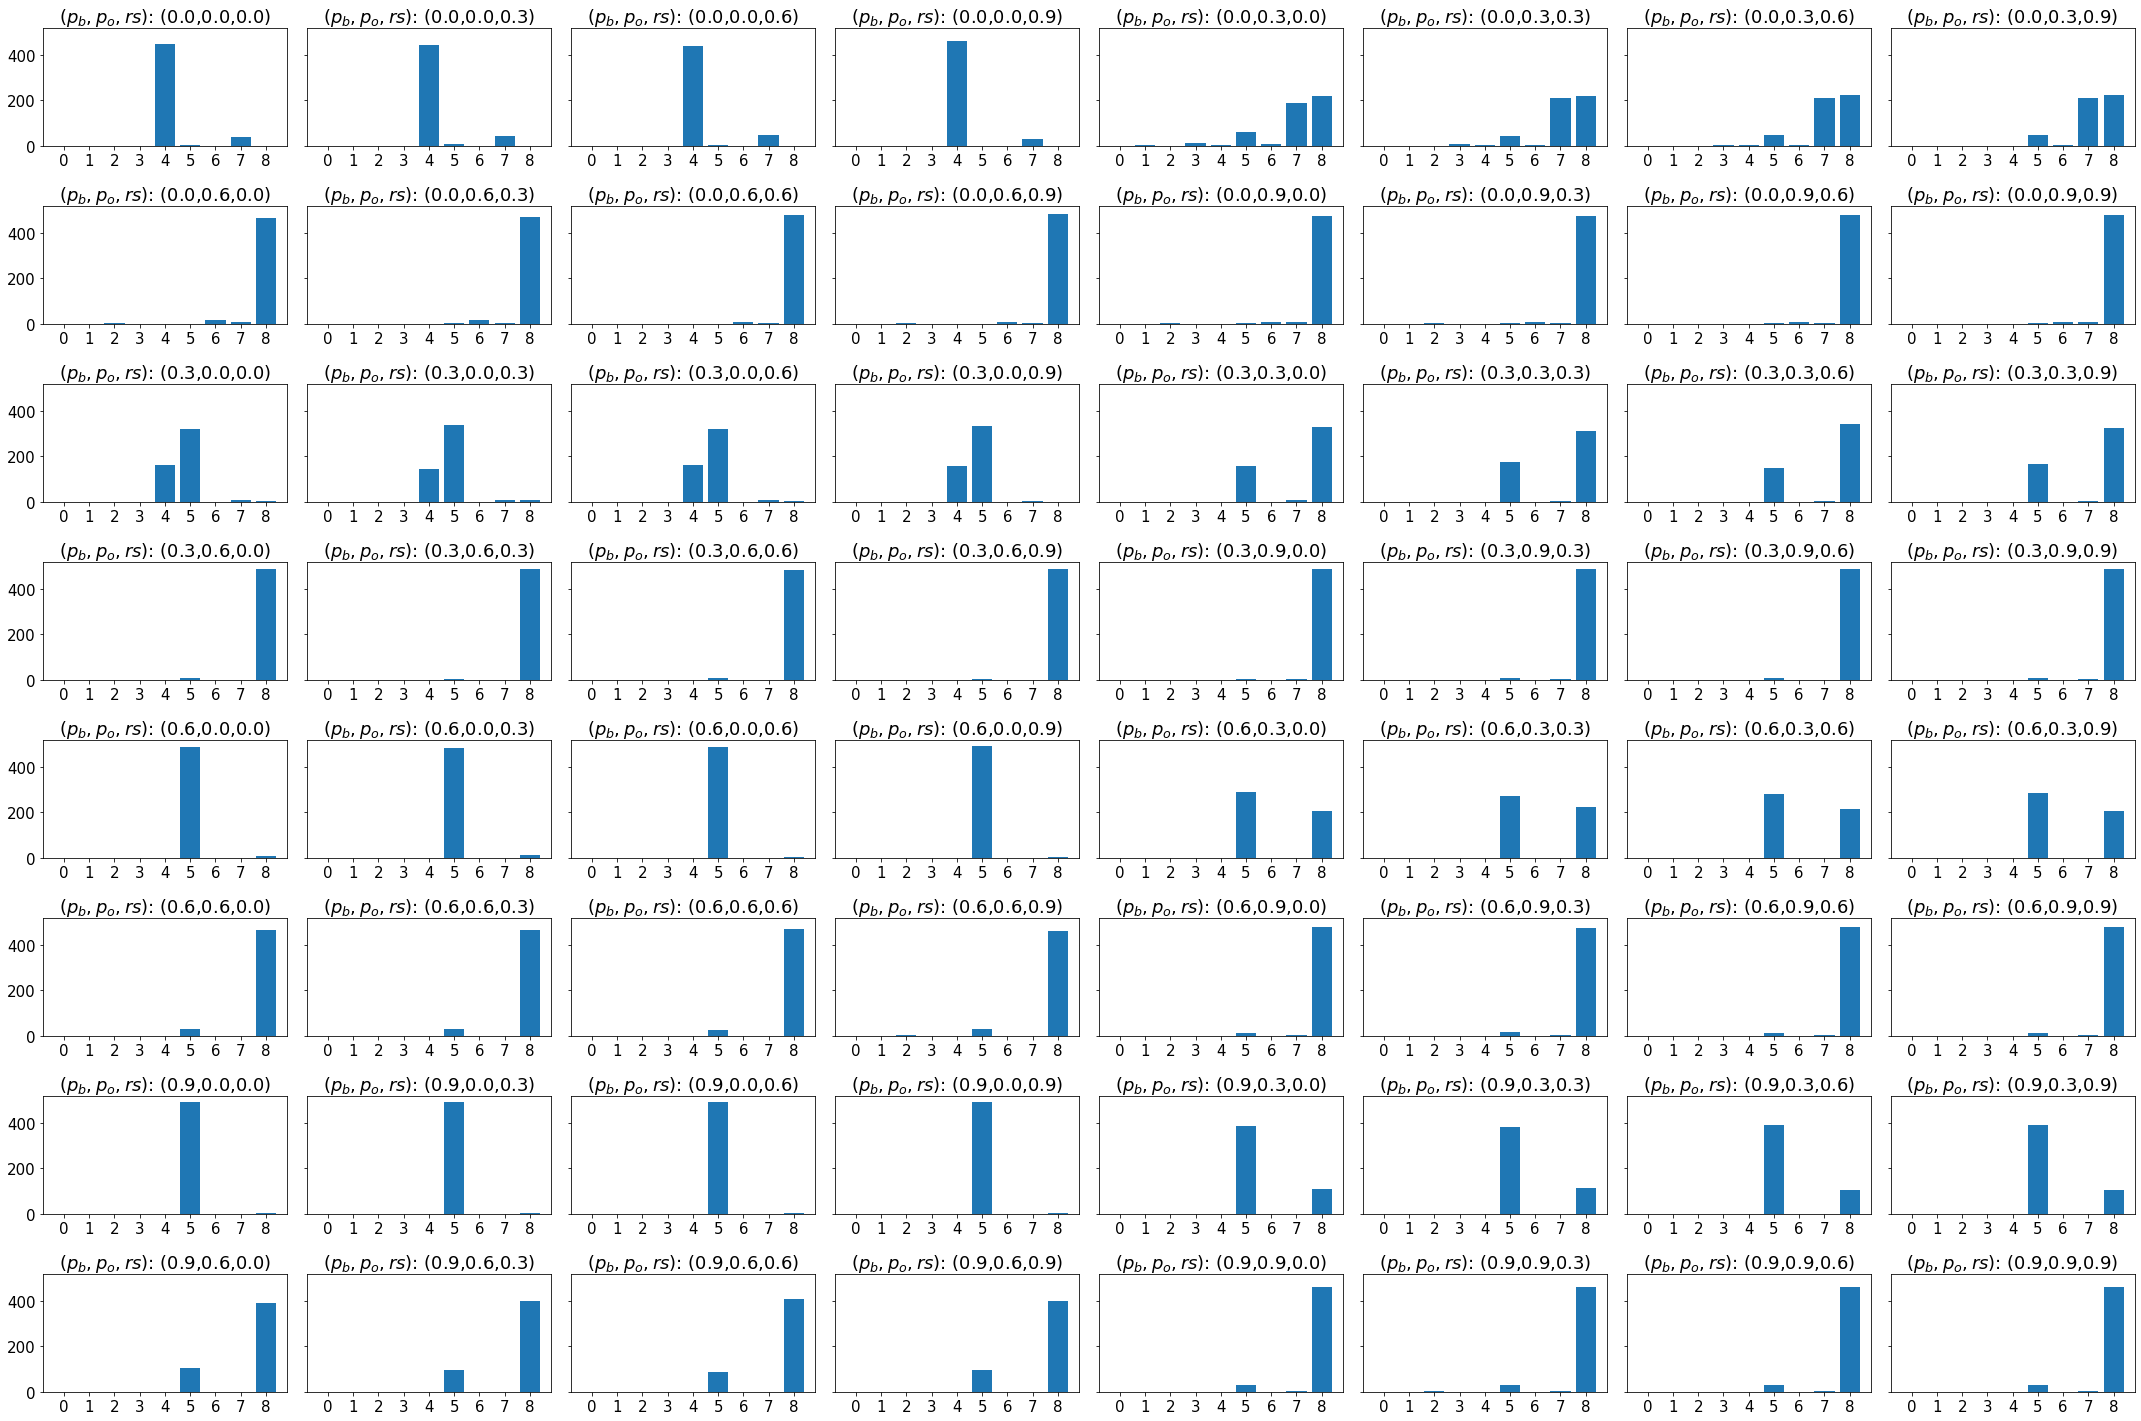

<Figure size 432x288 with 0 Axes>

In [400]:
fig, ax = plt.subplots(8,8,figsize=(30,20), sharey=True)
ax = ax.flatten()
for i in range(64):
    a = final_df1_long.loc[final_df1_long.Parameters == parameters[i]]
    ax[i].bar(a.Actions.values, a.Counts.values)
    ax[i].set_title('($p_{b},p_{o},rs$): ' + f'({parameters[i]})')
    ax[i].set_xticks(np.arange(9))
plt.tight_layout()
plt.show()
plt.savefig(path + 'best_response.png')

In [247]:
plt.rcParams.update({'font.size': 15})

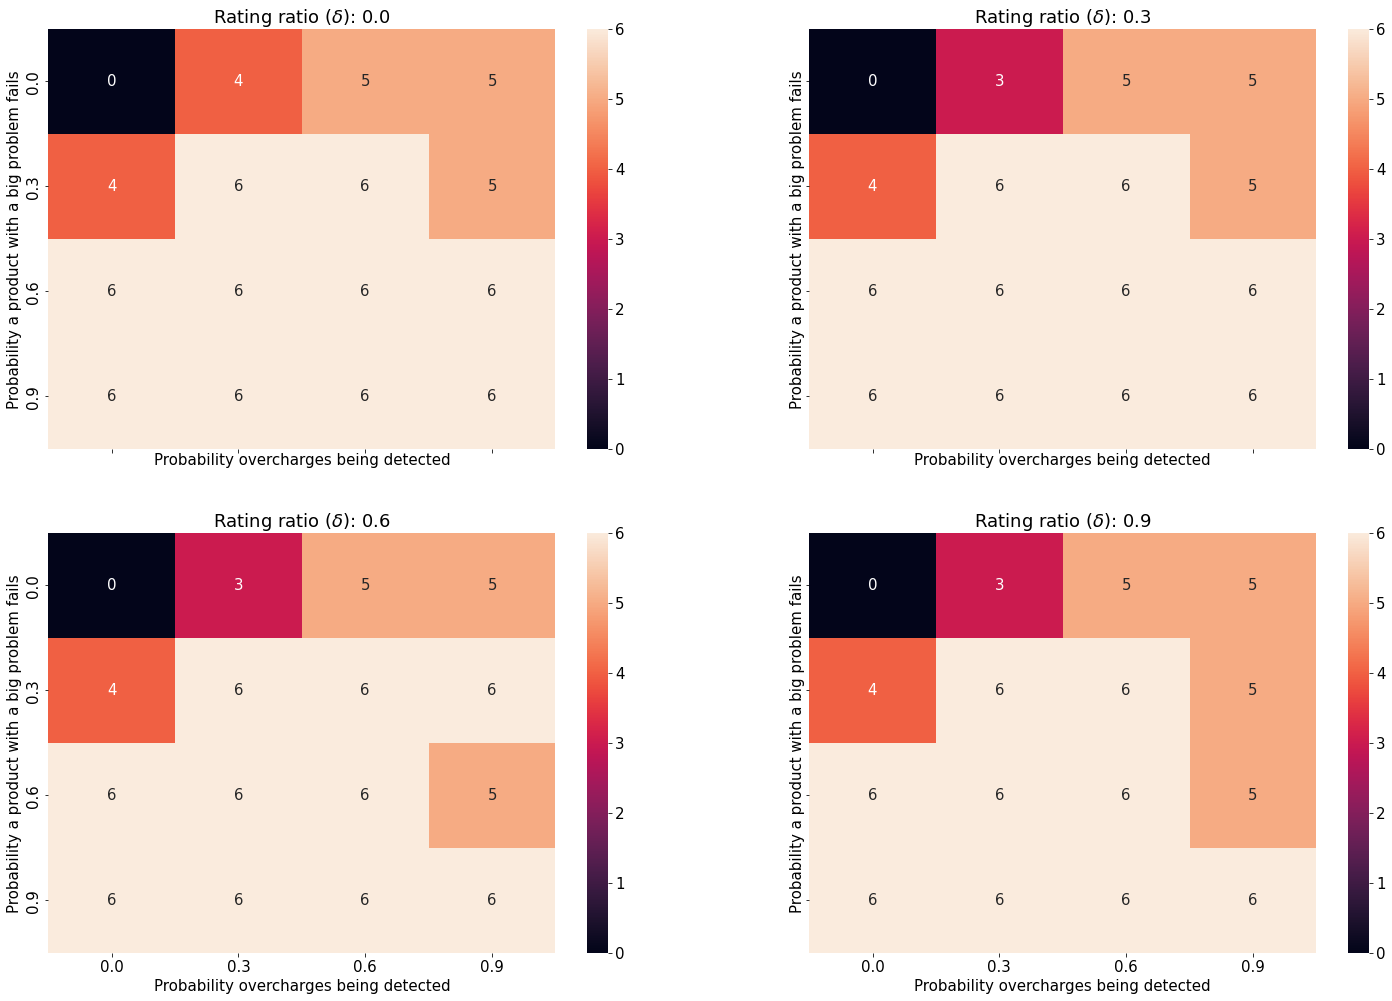

In [253]:
fig, ax = plt.subplots(2,2, sharey=True,sharex=True, figsize=(25,17))
ax = ax.flatten()
for idx, ratio in enumerate(np.round(np.arange(start=0, stop=1.2, step=0.3),2)):
    data = df.loc[df['rating_ratio'] == ratio]
    pivoted_data = data.pivot('prob_bproblem_fail', 'prob_overcharge_detected', 'scenario_fairness')
    sns.heatmap(pivoted_data, annot=True, ax=ax[idx])
    ax[idx].set_title(f'Rating ratio ($\delta$): {ratio}')
    ax[idx].set_xlabel('Probability overcharges being detected')
    ax[idx].set_ylabel('Probability a product with a big problem fails')

plt.savefig(path + 'Rating_ratio_scenarios.png', transparent=True)